In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
import math
from copy import deepcopy
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.distributions import StudentT

# Define the U-net based score prediction network

# Sampling the Frequency Vector $\mathbf{w}$

Let the total embedding dimension be $D$ (an even integer), and define  
$$
d \;=\; \frac{D}{2}
$$  
as the number of frequency pairs.

The frequency vector  
$$
\mathbf{w} \in \mathbb{R}^{d}
$$  
is sampled once at initialization from a Gaussian with standard deviation given by the `scale` hyperparameter:
$$
w_j \;\sim\; N\bigl(0,\;\text{scale}^2\bigr),
\quad
j = 1,2,\dots,d.
$$
## Time Encoding Function

Let the input timestep be $t \in \mathbb{R}$, the total embedding dimension be $D$ (even), and define  
$$
d = \frac{D}{2}
$$  
as the number of frequency pairs.  Let  
$$
\mathbf{w} = (w_{1}, w_{2}, \dots, w_{d}) \in \mathbb{R}^{d}
$$  
be the fixed frequency vector.

Then the time encoding $\phi: \mathbb{R} \to \mathbb{R}^{D}$ is given by the concatenation of sines and cosines at those frequencies:

$$
\phi(t) =
\begin{pmatrix}
\sin\bigl(2\pi\,w_{1}\,t\bigr)\\
\sin\bigl(2\pi\,w_{2}\,t\bigr)\\
\vdots\\
\sin\bigl(2\pi\,w_{d}\,t\bigr)\\[6pt]
\cos\bigl(2\pi\,w_{1}\,t\bigr)\\
\cos\bigl(2\pi\,w_{2}\,t\bigr)\\
\vdots\\
\cos\bigl(2\pi\,w_{d}\,t\bigr)
\end{pmatrix}
\;\in\;\mathbb{R}^{D}
$$

Equivalently, more compactly:

$$
\phi(t) \;=\;
\bigl[\,
\sin\bigl(2\pi\,t\,\mathbf{w}\bigr),
\;\cos\bigl(2\pi\,t\,\mathbf{w}\bigr)
\,\bigr]
\;\in\;\mathbb{R}^{D/2}\times\mathbb{R}^{D/2} \;=\; \mathbb{R}^{D}.
$$

For a batch of timesteps $\mathbf{t}\in\mathbb{R}^{B}$, you apply $\phi$ element-wise to obtain a $(B\times D)$ tensor.



In [2]:
class TimeEncoding(nn.Module):
    def __init__(self, embed_dim,scale=30):
      super().__init__()
      d =embed_dim//2
      w=torch.randn(d)*scale
      self.register_buffer('W',w,persistent=True)
    def forward(self,t):
      x_proj=t[:,None]*self.W[None,:]*2*math.pi
      return torch.cat([torch.sin(x_proj),torch.cos(x_proj)],dim=-1)

In [3]:
class Dense(nn.Module):
  def __init__(self,input_dim, output_dim):
    super().__init__()
    self.dense=nn.Linear(input_dim,output_dim)
  def forward(self,x):
    return self.dense(x)[...,None,None] #(B,output_dim)->(B, output_dim,1,1)

Assume an input activation tensor  
- $X\in\mathbb{R}^{B\times C\times H\times W}$,  
- with $C$ channels and we choose $G=4$ groups.  
Let each group have $M = C/G$ channels.  

For each sample $b$ and group $g$ (where $g=0,\dots,G-1$), define the set of channel indices  
$S_g = \{\,gM,\,gM+1,\,\dots,\, (g+1)M-1\}$.  

1. **Compute the group mean**  
$$
\mu_{b,g}
= \frac{1}{M\,H\,W}
\sum_{c\in S_g}
\sum_{h=1}^{H}
\sum_{w=1}^{W}
X_{b,c,h,w}
$$

2. **Compute the group variance**  
$$
\sigma^2_{b,g}
= \frac{1}{M\,H\,W}
\sum_{c\in S_g}
\sum_{h=1}^{H}
\sum_{w=1}^{W}
\bigl(X_{b,c,h,w} - \mu_{b,g}\bigr)^{2}
$$

3. **Normalize each element**  
For each channel $c\in S_g$:
$$
\hat X_{b,c,h,w}
= \frac{X_{b,c,h,w} - \mu_{b,g}}
       {\sqrt{\sigma^2_{b,g} + \epsilon}}
$$

4. **Apply learnable affine transform**  
With per‐channel scale $\gamma_c$ and bias $\beta_c$:
$$
Y_{b,c,h,w}
= \gamma_{c}\,\hat X_{b,c,h,w} + \beta_{c}
$$

This implements `nn.GroupNorm(4, num_channels=C)` in PyTorch.  


# For scalar data

In [4]:
class ScalarScoreNet(nn.Module):
    def __init__(self, t_dim=128, hidden_dim=256):
        super().__init__()
        # Enhanced time embedding with better scale
        self.time_mlp = nn.Sequential(
            TimeEncoding(embed_dim=t_dim, scale=30),
            nn.Linear(t_dim, t_dim),
            nn.SiLU(),  # SiLU often works better than Mish for score networks
            nn.Linear(t_dim, t_dim),
        )

        # Deeper network with residual connections
        self.net = nn.ModuleList([
            nn.Linear(1 + t_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, 1),
        ])

        # Group normalization for better training stability
        self.norms = nn.ModuleList([
            nn.GroupNorm(1, hidden_dim),  # Layer norm equivalent
            nn.GroupNorm(1, hidden_dim),
            nn.GroupNorm(1, hidden_dim),
            nn.GroupNorm(1, hidden_dim),
        ])

        # Initialize the final layer to output small values initially
        nn.init.zeros_(self.net[-1].weight)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, x_t, t):
        # x_t: (B,1), t: (B,)
        t_emb = self.time_mlp(t)  # → (B, t_dim)

        # Concatenate input and time embedding
        h = torch.cat([x_t, t_emb], dim=1)  # → (B, 1 + t_dim)

        # Forward through network with residual connections
        h = torch.tanh(self.net[0](h))  # First layer

        # Hidden layers with residual connections and normalization
        for i in range(1, 4):
            residual = h
            h = self.net[i](h)
            h = self.norms[i-1](h.unsqueeze(-1)).squeeze(-1)  # Add dummy dim for GroupNorm
            h = torch.tanh(h)
            if h.shape == residual.shape:  # Add residual if dimensions match
                h = h + residual

        # Final output layer
        output = self.net[-1](h)  # → (B,1)

        return output


# Define the SDE and Denoising Score Matching Objective

SDE is hand-designed, like any other hyper-parameters.

Now let's get our hands dirty on training. First of all, we need to specify an SDE that perturbs the data distribution $p_{0}$ to a prior distribution $p_{T}$. We choose the following SDE:

$$
dx = \sigma^{t}\,dw,\quad t\in[0,1].
$$

In this case,

$$
p_{0t}\bigl(x(t)\mid x(0)\bigr)
= N\Bigl(
x(t)\;;\;x(0),\;\frac{1}{2\log\sigma}\bigl(\sigma^{2t}-1\bigr)\,I
\Bigr).
$$

and we can choose the weighting function

$$
\lambda(t) \;=\;\mathrm{variance}
\;=\;\frac{1}{2\log\sigma}\bigl(\sigma^{2t}-1\bigr).
$$

When $\sigma$ is large, the prior distribution $p_{t=1}$ is

$$
p_{t=1}(x)
=\int p_{0}(y)\,N\Bigl(x ; y,\; \tfrac{1}{2\log\sigma}(\sigma^{2}-1)\,I\Bigr)\,dy
\approx N\Bigl(x ; 0,\; \tfrac{1}{2\log\sigma}(\sigma^{2}-1)\,I\Bigr),
$$

which is approximately independent of the data distribution and is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\tfrac{1}{2\log\sigma}(\sigma^{2t}-1)$. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_{0}$ to a simple Gaussian distribution $p_{1}$.


In [5]:
device='cuda'
def marginal_prob_std(t,sigma):
  if not torch.is_tensor(t):
      t = torch.tensor(t, device=device, dtype=torch.float32)
  elif t.device != torch.device(device):
      t = t.to(device)
  return torch.sqrt((sigma**(2*t)-1)/2/np.log(sigma))

def diffusion_coeff(t,sigma):
  if not torch.is_tensor(t):
      t = torch.tensor(t, device=device, dtype=torch.float32)
  elif t.device != torch.device(device):
      t = t.to(device)
  return sigma**t

sigma=25
marginal_prob_std_fn=functools.partial(marginal_prob_std,sigma=sigma)
diffusion_coeff_fn=functools.partial(diffusion_coeff,sigma=sigma)

The loss is defined as:
$$
\theta^{*} \;=\; \arg\min_{\theta}\; \mathbb{E}_{t}\biggl\{\;\lambda(t)\;\mathbb{E}_{x(0)}\;\mathbb{E}_{x(t)\mid x(0)}\bigl[\bigl\lVert s_{\theta}\bigl(x(t),\,t\bigr)\;-\;\nabla_{x(t)}\log p_{0t}\bigl(x(t)\mid x(0)\bigr)\bigr\rVert_{2}^{2}\bigr]\biggr\}.
$$
where in this speical case:
$$ \nabla_{x(t)}\log p_{0t}\bigl(x(t)\mid x(0)\bigr)=-\frac{\epsilon}{\sigma} $$
$$ \lambda(t)=\sigma^2$$

In [6]:
class EMA(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super(EMA, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device  # perform EMA on different device from model if set
        if self.device is not None:
            self.module.to(device=self.device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(),
                                      model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(
            model,
            update_fn=lambda e, m: self.decay * e + (1.0 - self.decay) * m
        )

    def set(self, model):
        self._update(
            model,
            update_fn=lambda e, m: m
        )

## Training for scalar data

In [7]:
def loss_fn_scalar(model, x0, marginal_prob_std_fn, eps=1e-5):
    """
    Score matching loss with proper weighting for scalar data.
    """
    batch_size = x0.shape[0]
    # Sample random times
    t = torch.rand(batch_size, device=x0.device) * (1.0 - eps) + eps

    # Sample noise
    z = torch.randn_like(x0)

    # Get standard deviation at time t
    std = marginal_prob_std_fn(t).unsqueeze(1)  # (B, 1)

    # Perturb data: x_t = x_0 + noise * std
    perturbed_x = x0 + z * std

    # Get score prediction
    score = model(perturbed_x, t)

    # True score is -z/std (negative gradient of log probability)
    target_score = -z / std

    # Loss: ||s_θ(x_t, t) - (−z/σ)||²
    # Weight by std² to match the theory
    loss = torch.mean((score - target_score) ** 2 * (std ** 2))

    return loss

# — Build a Student-T dataset —
nu = 2.0  # degrees of freedom
N = 100_000
batch_size = 64  # Increased batch size
student_t = StudentT(nu)
data = student_t.sample((N, 1))
dataset = TensorDataset(data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# — Instantiate model, optimizer, EMA —
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Larger model with more capacity
score_model = nn.DataParallel(ScalarScoreNet(t_dim=128, hidden_dim=256)).to(device)
optimizer = Adam(score_model.parameters(), lr=2e-4)  # Slightly higher learning rate
ema = EMA(score_model, decay=0.999, device=device)  # Faster EMA decay

# — Training loop —
n_epochs = 30  # More epochs
for epoch in range(1, n_epochs + 1):
    total_loss = 0.0
    count = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch}")
    for (x0_batch,) in pbar:
        x0 = x0_batch.to(device)
        optimizer.zero_grad()
        loss = loss_fn_scalar(score_model, x0, marginal_prob_std_fn)
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(score_model.parameters(), 1.0)

        optimizer.step()
        ema.update(score_model)

        total_loss += loss.item() * x0.size(0)
        count += x0.size(0)
        pbar.set_postfix(loss=total_loss / count)

    avg = total_loss / count
    print(f"[Epoch {epoch:02d}] Avg score-matching loss = {avg:.4e}")

    # Save checkpoint every 5 epochs
    if epoch % 5 == 0:
        torch.save({
            'model_state_dict': score_model.state_dict(),
            'ema_state_dict': ema.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': avg
        }, f"scalar_ckpt_{epoch}.pth")

Epoch 1: 100%|██████████| 1563/1563 [00:13<00:00, 120.03it/s, loss=0.521]


[Epoch 01] Avg score-matching loss = 5.2126e-01


Epoch 2: 100%|██████████| 1563/1563 [00:11<00:00, 130.47it/s, loss=0.492]


[Epoch 02] Avg score-matching loss = 4.9166e-01


Epoch 3: 100%|██████████| 1563/1563 [00:11<00:00, 131.63it/s, loss=0.5]


[Epoch 03] Avg score-matching loss = 4.9986e-01


Epoch 4: 100%|██████████| 1563/1563 [00:11<00:00, 130.60it/s, loss=0.492]


[Epoch 04] Avg score-matching loss = 4.9150e-01


Epoch 5: 100%|██████████| 1563/1563 [00:11<00:00, 132.22it/s, loss=0.494]


[Epoch 05] Avg score-matching loss = 4.9427e-01


Epoch 6: 100%|██████████| 1563/1563 [00:11<00:00, 130.58it/s, loss=0.49]


[Epoch 06] Avg score-matching loss = 4.9009e-01


Epoch 7: 100%|██████████| 1563/1563 [00:12<00:00, 127.14it/s, loss=0.488]


[Epoch 07] Avg score-matching loss = 4.8820e-01


Epoch 8: 100%|██████████| 1563/1563 [00:12<00:00, 124.37it/s, loss=0.483]


[Epoch 08] Avg score-matching loss = 4.8326e-01


Epoch 9: 100%|██████████| 1563/1563 [00:11<00:00, 130.37it/s, loss=0.486]


[Epoch 09] Avg score-matching loss = 4.8604e-01


Epoch 10: 100%|██████████| 1563/1563 [00:11<00:00, 131.48it/s, loss=0.488]


[Epoch 10] Avg score-matching loss = 4.8771e-01


Epoch 11: 100%|██████████| 1563/1563 [00:11<00:00, 131.05it/s, loss=0.485]


[Epoch 11] Avg score-matching loss = 4.8467e-01


Epoch 12: 100%|██████████| 1563/1563 [00:11<00:00, 130.73it/s, loss=0.485]


[Epoch 12] Avg score-matching loss = 4.8533e-01


Epoch 13: 100%|██████████| 1563/1563 [00:11<00:00, 131.56it/s, loss=0.484]


[Epoch 13] Avg score-matching loss = 4.8390e-01


Epoch 14: 100%|██████████| 1563/1563 [00:12<00:00, 130.20it/s, loss=0.482]


[Epoch 14] Avg score-matching loss = 4.8210e-01


Epoch 15: 100%|██████████| 1563/1563 [00:11<00:00, 131.33it/s, loss=0.487]


[Epoch 15] Avg score-matching loss = 4.8686e-01


Epoch 16: 100%|██████████| 1563/1563 [00:11<00:00, 130.82it/s, loss=0.489]


[Epoch 16] Avg score-matching loss = 4.8915e-01


Epoch 17: 100%|██████████| 1563/1563 [00:12<00:00, 129.68it/s, loss=0.487]


[Epoch 17] Avg score-matching loss = 4.8660e-01


Epoch 18: 100%|██████████| 1563/1563 [00:11<00:00, 130.37it/s, loss=0.493]


[Epoch 18] Avg score-matching loss = 4.9324e-01


Epoch 19: 100%|██████████| 1563/1563 [00:11<00:00, 130.56it/s, loss=0.48]


[Epoch 19] Avg score-matching loss = 4.7971e-01


Epoch 20: 100%|██████████| 1563/1563 [00:11<00:00, 131.20it/s, loss=0.491]


[Epoch 20] Avg score-matching loss = 4.9061e-01


Epoch 21: 100%|██████████| 1563/1563 [00:11<00:00, 132.99it/s, loss=0.483]


[Epoch 21] Avg score-matching loss = 4.8331e-01


Epoch 22: 100%|██████████| 1563/1563 [00:11<00:00, 133.02it/s, loss=0.486]


[Epoch 22] Avg score-matching loss = 4.8601e-01


Epoch 23: 100%|██████████| 1563/1563 [00:11<00:00, 132.21it/s, loss=0.489]


[Epoch 23] Avg score-matching loss = 4.8887e-01


Epoch 24: 100%|██████████| 1563/1563 [00:11<00:00, 131.75it/s, loss=0.489]


[Epoch 24] Avg score-matching loss = 4.8891e-01


Epoch 25: 100%|██████████| 1563/1563 [00:11<00:00, 131.84it/s, loss=0.485]


[Epoch 25] Avg score-matching loss = 4.8527e-01


Epoch 26: 100%|██████████| 1563/1563 [00:12<00:00, 129.31it/s, loss=0.486]


[Epoch 26] Avg score-matching loss = 4.8613e-01


Epoch 27: 100%|██████████| 1563/1563 [00:12<00:00, 129.62it/s, loss=0.487]


[Epoch 27] Avg score-matching loss = 4.8670e-01


Epoch 28: 100%|██████████| 1563/1563 [00:11<00:00, 130.48it/s, loss=0.487]


[Epoch 28] Avg score-matching loss = 4.8692e-01


Epoch 29: 100%|██████████| 1563/1563 [00:12<00:00, 128.04it/s, loss=0.486]


[Epoch 29] Avg score-matching loss = 4.8554e-01


Epoch 30: 100%|██████████| 1563/1563 [00:12<00:00, 129.74it/s, loss=0.48]


[Epoch 30] Avg score-matching loss = 4.8017e-01


#Sampling

In [8]:
# Diagnostic: Check model behavior at different times
def diagnose_model(model, data_sample, marginal_prob_std_fn, device):
    """Diagnose how well the model predicts scores at different noise levels."""
    model.eval()

    # Take a small sample of real data
    x0 = data_sample[:100].to(device)  # (100, 1)

    # Test at different time points
    test_times = torch.tensor([0.1, 0.3, 0.5, 0.7, 0.9], device=device)

    print("Model diagnostics:")
    print("Time\tNoise Std\tScore Mean\tScore Std\tExpected Score Std")
    print("-" * 65)

    with torch.no_grad():
        for t_val in test_times:
            t = torch.full((100,), t_val, device=device)

            # Add noise
            z = torch.randn_like(x0)
            std = marginal_prob_std_fn(t).unsqueeze(1)
            x_t = x0 + z * std

            # Get model prediction
            score_pred = model(x_t, t)

            # True score should be -z/std
            score_true = -z / std

            print(f"{t_val:.1f}\t{std.mean():.4f}\t\t{score_pred.mean():.4f}\t\t{score_pred.std():.4f}\t\t{score_true.std():.4f}")

    print()

# Run diagnostics before sampling
print("Running model diagnostics...")
diagnose_model(ema.module, data[:1000], marginal_prob_std_fn, device)

Running model diagnostics...
Model diagnostics:
Time	Noise Std	Score Mean	Score Std	Expected Score Std
-----------------------------------------------------------------
0.1	0.3747		0.0677		0.6977		2.6701
0.3	0.9572		0.0480		0.5111		0.9999
0.5	1.9308		0.0372		0.4033		0.5120
0.7	3.7306		0.0043		0.2506		0.2660
0.9	7.1304		0.0115		0.1361		0.1382



##Euler Sampling

Recall that for any SDE of the form

$$
dx = f(x, t)\,dt + g(t)\,dw,
$$

the reverse‐time SDE is given by

$$
dx = \bigl[f(x, t) - g(t)^2\,\nabla_x\log p_t(x)\bigr]\,dt + g(t)\,d\bar w.
$$

Since we have chosen the forward SDE to be

$$
dx = \sigma^t\,dw,\quad t\in[0,1],
$$

the reverse‐time SDE is

$$
dx = -\,\sigma^{2t}\,\nabla_x\log p_t(x)\,dt + \sigma^t\,d\bar w.
$$

In particular, using our time‐dependent score‐based model, the reverse‐time SDE can be approximated by

$$
dx = -\,\sigma^{2t}\,s_\theta(x,t)\,dt + \sigma^t\,d\bar w.
$$

To sample from our time‐dependent score‐based model $s_\theta(x,t)$, we first draw a sample from the prior distribution

$$
p_{1} \approx \mathcal{N}\Bigl(x;0,\;\tfrac{1}{2\log\sigma}(\sigma^{2}-1)\,I\Bigr),
$$

and then solve the reverse‐time SDE with numerical methods, such as the Euler–Maruyama approach.  Replacing $dt$ with $\Delta t$ and $dw$ with $z_t\sim\mathcal{N}(0,\,g^2(t)\,\Delta t\,I)$, we obtain the iteration

$$
x_{\,t-\Delta t}
= x_{t}
  + \sigma^{2t}\,s_\theta(x_t,\,t)\,\Delta t
  + \sigma^t\,\sqrt{\Delta t}\;z_t,
\quad
z_t \sim \mathcal{N}(0,\,I).
$$


In [9]:
num_steps=500
def euler_sampler_scalar(score_model,marginal_prob_std,diffusion_coeff,batch_size=64,num_steps=num_steps,device='cuda',eps=1e-3):
  t=torch.ones(batch_size,device=device)
  init_x=torch.randn(batch_size,1,device=device)*marginal_prob_std(t)[:,None]
  time_steps=torch.linspace(1,eps,num_steps,device=device)
  step_size=time_steps[0]-time_steps[1]
  x=init_x
  with torch.no_grad():
    for time_step in tqdm.tqdm(time_steps):
      batch_time_step=torch.ones(batch_size,device=device)*time_step
      g=diffusion_coeff(batch_time_step)
      mean_x=x+(g**2)[:,None]*score_model(x,batch_time_step)*step_size
      z=torch.randn_like(x)
      x=mean_x+torch.sqrt(step_size)*g[:,None]*z
  return mean_x


## PC sampler

corrector:
$$ x_t ← x_t+α s_θ(x_t,t)+\sqrt{2α} z$$
predictor:
$$x_{t-Δt}=\mu+g_t \sqrt{Δt} z$$
where $\mu=x_t+g_t^2s_\theta (x_t,t)Δt$


In [10]:
signal_to_noise_ratio = 0.16
num_steps = 500

def pc_sampler(
    score_model,
    marginal_prob_std,
    diffusion_coeff,
    batch_size=64,
    num_steps=num_steps,
    snr=signal_to_noise_ratio,
    device='cuda',
    eps=1e-3
):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
        score_model: A PyTorch model that represents the time-dependent score-based model.
        marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
        diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
        batch_size: The number of samplers to generate by calling this function once.
        num_steps: The number of sampling steps. Equivalent to the number of discretized time steps.
        snr: Signal-to-noise ratio for the corrector updates.
        device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
        eps: The smallest time step for numerical stability.

    Returns:
        Samples.
    """

    # 1) Initialize from the prior at t=1
    t = torch.ones(batch_size, device=device)
    init_noise = torch.randn_like(score_model.module.conv1.weight[:, :1, :1].unsqueeze(0))  # dummy to get (1,1,H,W)
    # Actually just sample standard normal image noise:
    with torch.no_grad():
        x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]

    # 2) Set up the time grid
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size  = time_steps[0] - time_steps[1]

    # 3) Loop over reverse time
    with torch.no_grad():
        for time_step in tqdm.tqdm(time_steps, desc='PC sampling'):
            # expand to per-sample
            batch_t = torch.full((batch_size,), time_step, device=device)
            # ---- Predictor: Euler–Maruyama ----
            g = diffusion_coeff(time_step)                              # g(t)
            score = score_model(x, batch_t)
            # mean update
            x_mean = x + (g**2)[:, None, None, None] * score * step_size
            # stochastic update
            x = x_mean + torch.sqrt((g**2) * step_size)[:, None, None, None] * torch.randn_like(x)


            # ---- Corrector: Langevin MCMC ----
            grad = score_model(x, batch_t)                           # ∇x log p_t(x)
            # compute norms per-sample
            grad_norm  = torch.norm(grad.reshape(batch_size, -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:])) #\sqrt{C\,H\,W}
            # step size for Langevin
            langevin_step = (snr * noise_norm / grad_norm) ** 2 * 2
            print(f'{langevin_step=}')
            # one Langevin update
            for _ in range(10):
                x = x + langevin_step * grad + torch.sqrt(2 * langevin_step) * torch.randn_like(x)
                grad=score_model(x,batch_t)
                grad_norm=torch.norm(grad.reshape(batch_size,-1),dim=-1).mean()
                noise_norm=np.sqrt(np.prod(x.shape[1:]))
                langevin_step=(snr*noise_norm/grad_norm)**2*2
                print(f'{langevin_step=}')


    # 4) Return the final denoised mean
    return x_mean

##Sampler for scalar

In [13]:
import torch
import tqdm

def pc_sampler_scalar(
    score_model,
    marginal_prob_std,
    diffusion_coeff,
    batch_size=64,
    num_steps=1000,  # More steps for better quality
    snr=0.15,  # Slightly lower SNR for stability
    device='cuda',
    eps=1e-4,  # Smaller eps for better coverage
    corrector_steps=1
):
    """
    Enhanced Predictor–Corrector sampler for 1-D data (e.g., Student-t).

    Args:
        score_model: a model mapping (x_t of shape (B,1), t of shape (B,)) → (B,1)
        marginal_prob_std: function t→σ̄(t)
        diffusion_coeff: function t→g(t)
        batch_size: number of samples to generate
        num_steps: number of discretization steps (time grid from 1→eps)
        snr: signal-to-noise ratio for Langevin corrector
        device: 'cuda' or 'cpu'
        eps: smallest time to end at
        corrector_steps: number of Langevin steps per time

    Returns:
        x_mean: final denoised samples of shape (batch_size,1)
    """
    # 1) Initialize from proper prior at t=1
    t_init = torch.ones(batch_size, device=device)
    init_std = marginal_prob_std(t_init)

    with torch.no_grad():
        # Sample from the correct prior distribution
        x = torch.randn(batch_size, 1, device=device) * init_std.unsqueeze(1)

    # 2) Time grid with more steps for better accuracy
    time_steps = torch.linspace(1.0, eps, num_steps, device=device)
    dt = time_steps[0] - time_steps[1]

    # 3) Reverse SDE with Predictor–Corrector
    with torch.no_grad():
        for i, time_step in enumerate(tqdm.tqdm(time_steps, desc='PC sampling (scalar)')):
            batch_t = torch.full((batch_size,), time_step, device=device)

            # Predictor: Euler–Maruyama with adaptive step size
            g = diffusion_coeff(time_step)  # g(t), scalar
            score = score_model(x, batch_t)  # sθ(x_t, t), shape (B,1)

            # Adaptive step size based on score magnitude
            score_norm = torch.norm(score, dim=1).mean()
            adaptive_dt = dt * min(1.0, 1.0 / (score_norm + 1e-6))

            # Predictor step
            drift = (g**2) * score * adaptive_dt
            x_mean = x + drift

            # Add noise only if not at the final step
            if i < len(time_steps) - 1:
                noise = g * torch.sqrt(adaptive_dt) * torch.randn_like(x)
                x = x_mean + noise
            else:
                x = x_mean

            # Corrector: Langevin MCMC with improved step size
            if i < len(time_steps) - 10:  # Skip corrector near the end
                for _ in range(corrector_steps):
                    grad = score_model(x, batch_t)  # ∇ₓ log pₜ(x)

                    # Compute norms more carefully
                    grad_norm = torch.norm(grad, dim=1).mean()
                    noise_norm = 1.0  # for scalar data

                    # Improved step size calculation
                    if grad_norm > 1e-8:
                        alpha = torch.tensor(min((snr * noise_norm / grad_norm)**2 * 2.0, 1e-3),device=device)
                    else:
                        alpha = torch.tensor(1e-5,device=device)

                    # Langevin update with clamping for numerical stability
                    langevin_noise = torch.sqrt(2 * alpha) * torch.randn_like(x)
                    x = x + alpha * grad + langevin_noise

                    # Clamp to reasonable range to avoid numerical instability
                    x = torch.clamp(x, -10, 10)

    # 4) Return final denoised samples
    return x


In [14]:
# Use the EMA model for sampling
sampling_model = ema.module
sampling_model.eval()

# Draw M samples with better parameters
M = 2000  # More samples for better statistics
batch_size = 32
samples = []

print("Generating samples...")
with torch.no_grad():
    num_batches = (M + batch_size - 1) // batch_size  # ceiling division
    for i in range(num_batches):
        current_batch_size = min(batch_size, M - i * batch_size)
        x_gen = pc_sampler_scalar(
            sampling_model,
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            batch_size=current_batch_size,
            num_steps=1000,  # More steps
            snr=0.15,        # Better SNR
            device=device,
            eps=1e-4,        # Smaller eps
            corrector_steps=1
        )
        samples.append(x_gen.cpu())

# Concatenate samples
samples = torch.cat(samples, dim=0).numpy().squeeze()  # shape (M,)
print(f"Generated {len(samples)} samples")

# Calculate some statistics for comparison
real_data = data.numpy().squeeze()
print(f"\nStatistics comparison:")
print(f"Real data - Mean: {real_data.mean():.4f}, Std: {real_data.std():.4f}")
print(f"Generated - Mean: {samples.mean():.4f}, Std: {samples.std():.4f}")
print(f"Real data - Min: {real_data.min():.4f}, Max: {real_data.max():.4f}")
print(f"Generated - Min: {samples.min():.4f}, Max: {samples.max():.4f}")

# Calculate percentiles
import numpy as np
real_percentiles = np.percentile(real_data, [5, 25, 50, 75, 95])
gen_percentiles = np.percentile(samples, [5, 25, 50, 75, 95])
print(f"Real percentiles (5,25,50,75,95): {real_percentiles}")
print(f"Gen percentiles (5,25,50,75,95): {gen_percentiles}")


Generating samples...


PC sampling (scalar): 100%|██████████| 1000/1000 [00:02<00:00, 336.36it/s]


Generated 2000 samples

Statistics comparison:
Real data - Mean: 0.0145, Std: 3.5762
Generated - Mean: 0.0211, Std: 1.6944
Real data - Min: -152.2492, Max: 470.2719
Generated - Min: -8.3542, Max: 9.8745
Real percentiles (5,25,50,75,95): [-2.93508142e+00 -8.16789776e-01  1.34213141e-03  8.19948345e-01
  2.94162909e+00]
Gen percentiles (5,25,50,75,95): [-2.62078594 -0.79278481  0.02744177  0.78371567  2.5911729 ]


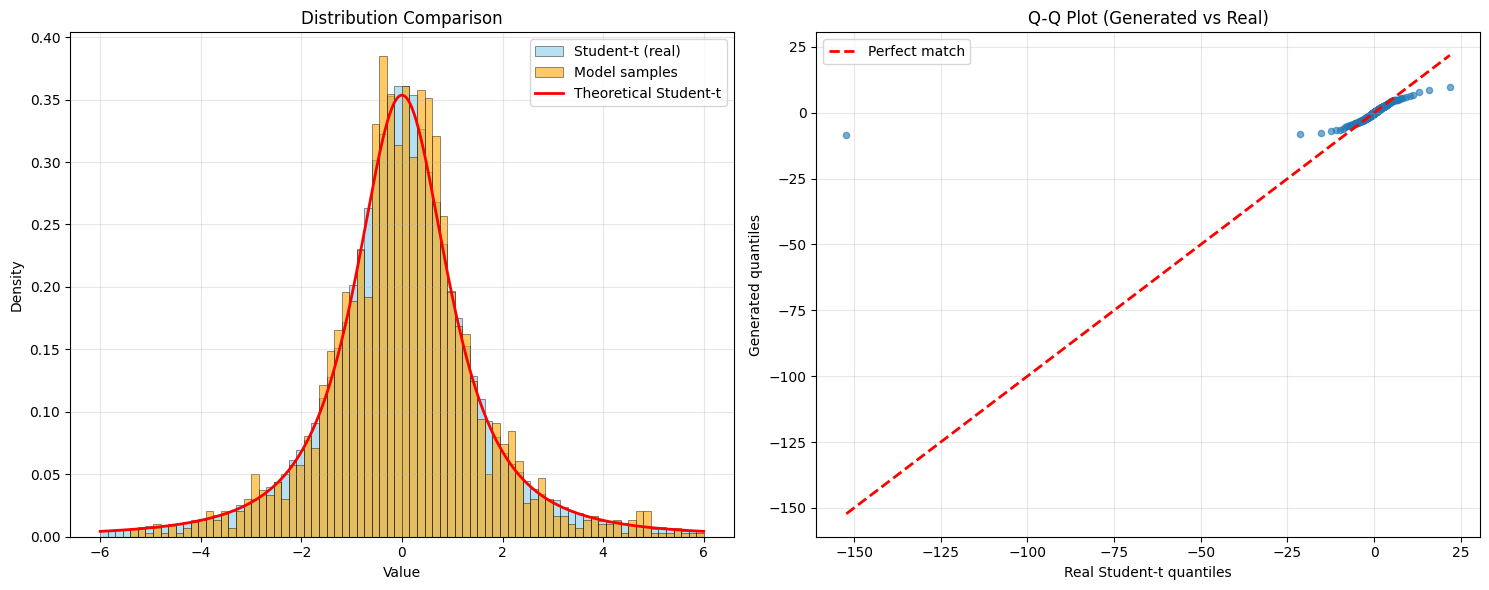


Wasserstein distance between real and generated: 0.2685
(Lower is better - 0 means identical distributions)
Kolmogorov-Smirnov test: statistic=0.0194, p-value=0.4447
(Lower KS statistic and higher p-value indicate better match)


In [15]:
# Enhanced visualization with theoretical comparison
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create a larger figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Histogram comparison
range_val = (-6, 6)
bins = 80

# Real data histogram
ax1.hist(real_data, bins=bins, density=True, alpha=0.6, range=range_val,
         label="Student-t (real)", color='skyblue', edgecolor='black', linewidth=0.5)

# Generated data histogram
ax1.hist(samples, bins=bins, density=True, alpha=0.6, range=range_val,
         label="Model samples", color='orange', edgecolor='black', linewidth=0.5)

# Theoretical Student-t PDF
x_theory = np.linspace(-6, 6, 1000)
theoretical_pdf = stats.t.pdf(x_theory, df=nu)
ax1.plot(x_theory, theoretical_pdf, 'r-', linewidth=2, label='Theoretical Student-t')

ax1.set_xlabel('Value')
ax1.set_ylabel('Density')
ax1.set_title('Distribution Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Q-Q plot for better comparison
from scipy.stats import probplot

# Generate theoretical quantiles
real_sorted = np.sort(real_data)
gen_sorted = np.sort(samples)

# Sample the same number of points for fair comparison
n_points = min(len(real_sorted), len(gen_sorted), 1000)
real_sample = real_sorted[::len(real_sorted)//n_points][:n_points]
gen_sample = gen_sorted[::len(gen_sorted)//n_points][:n_points]

ax2.scatter(real_sample, gen_sample, alpha=0.6, s=20)
min_val = min(real_sample.min(), gen_sample.min())
max_val = max(real_sample.max(), gen_sample.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect match')
ax2.set_xlabel('Real Student-t quantiles')
ax2.set_ylabel('Generated quantiles')
ax2.set_title('Q-Q Plot (Generated vs Real)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate Wasserstein distance as a quantitative measure
from scipy.stats import wasserstein_distance
w_distance = wasserstein_distance(real_data, samples)
print(f"\nWasserstein distance between real and generated: {w_distance:.4f}")
print("(Lower is better - 0 means identical distributions)")

# Calculate KS test
from scipy.stats import ks_2samp
ks_stat, ks_pvalue = ks_2samp(real_data, samples)
print(f"Kolmogorov-Smirnov test: statistic={ks_stat:.4f}, p-value={ks_pvalue:.4f}")
print("(Lower KS statistic and higher p-value indicate better match)")